<a href="https://colab.research.google.com/github/Bhanukiran111/Mern_Fullstack/blob/main/Pre_trained_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import kagglehub
path = kagglehub.dataset_download("hasibzunair/rsud20k-bangladesh-road-scene-understanding")
print("Path to dataset files:", path)

100%|██████████| 10.2G/10.2G [02:27<00:00, 74.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding/versions/1


Path to dataset files: /root/.cache/kagglehub/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding/versions/1
{'person': 0, 'rickshaw': 1, 'rickshaw van': 2, 'auto rickshaw': 3, 'truck': 4, 'pickup truck': 5, 'private car': 6, 'motorcycle': 7, 'bicycle': 8, 'bus': 9, 'micro bus': 10, 'covered van': 11, 'human hauler': 12, '': 14}


Processing test set: 100%|██████████| 649/649 [00:12<00:00, 50.27it/s]


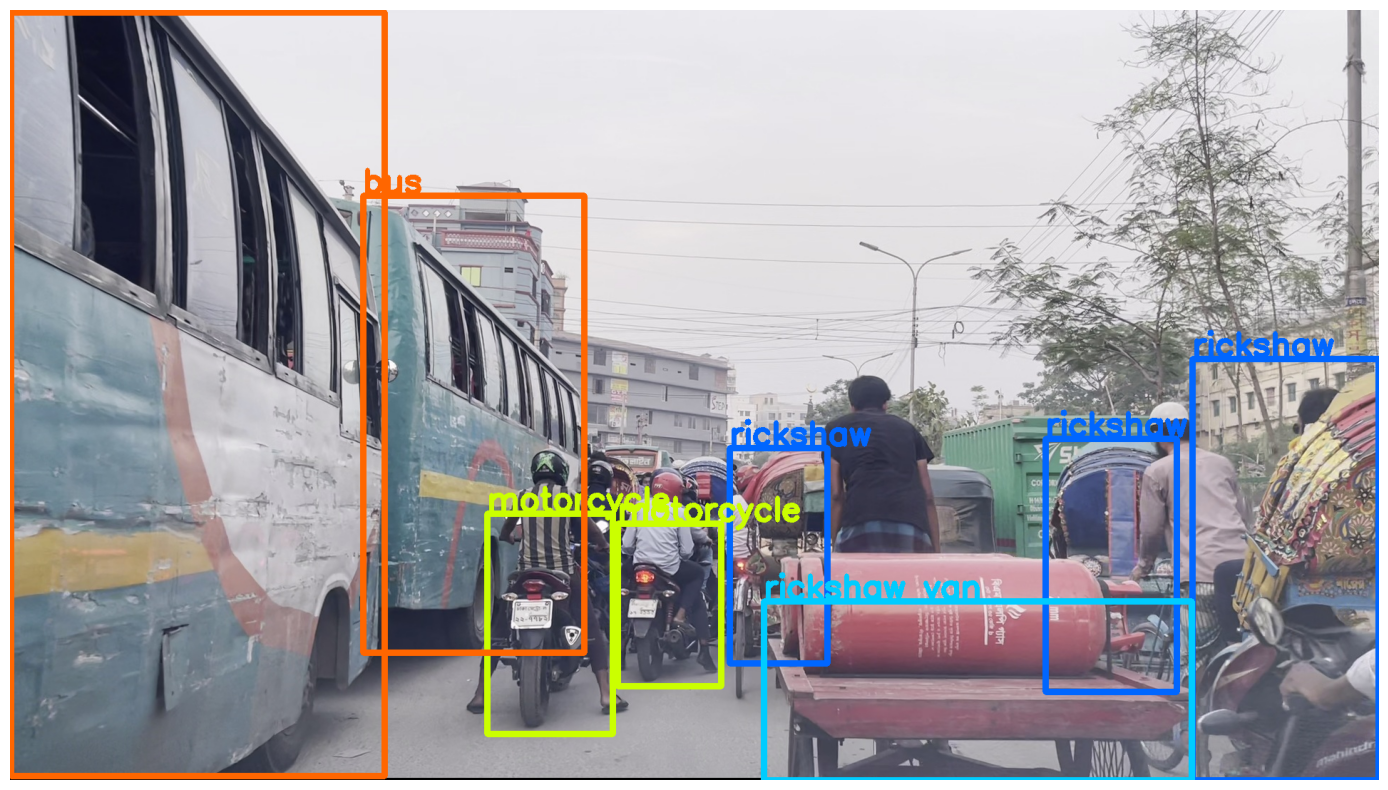

In [2]:
# Install required packages
!pip install kagglehub pybboxes opencv-python-headless

# Import necessary libraries
import kagglehub
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import pybboxes as pbx
import matplotlib.pyplot as plt
import colorsys

# Download the dataset and get the path
# This line was missing, causing the error
path = kagglehub.dataset_download("hasibzunair/rsud20k-bangladesh-road-scene-understanding")
print("Path to dataset files:", path)

# Dataset root path
data_root = os.path.join(path, "rsud20k")

# Load class labels
with open(os.path.join(data_root, 'classes.txt'), 'r') as f:
    class_labels = [line.strip() for line in f.readlines()]

class_label_map = {class_labels[i]: i for i in range(len(class_labels))}
print(class_label_map)

# Helper functions
def get_possible_box_format(bbox, input_shape=None):
    voc_bbox = pbx.convert_bbox(bbox, from_type="yolo", to_type="voc", image_size=input_shape)
    coco_bbox = pbx.convert_bbox(bbox, from_type="yolo", to_type="coco", image_size=input_shape)
    voc_bbox  = ', '.join(map(str, voc_bbox))
    coco_bbox = ', '.join(map(str, coco_bbox))
    yolo_bbox = ', '.join(map(str, bbox))
    return voc_bbox, coco_bbox, yolo_bbox

def prepare_dataframe(data_set='train'):
    image_path = os.path.join(data_root, 'images', data_set)
    label_path = os.path.join(data_root, 'labels', data_set)

    data = []
    for image_file in tqdm(os.listdir(image_path), desc=f'Processing {data_set} set'):
        img_h, img_w = cv2.imread(os.path.join(image_path, image_file)).shape[:2]
        image_id = image_file.split('.')[0]
        with open(os.path.join(label_path, image_id + '.txt'), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_label, *bbox = map(float, line.strip().split())
                class_label = int(class_label)
                voc_bbox, coco_bbox, yolo_bbox = get_possible_box_format(
                    bbox, input_shape=(img_w, img_h)
                )
                class_name = class_labels[class_label]
                data.append(
                    {
                        'image_id': image_id,
                        'voc_bbox': voc_bbox,
                        'coco_bbox': coco_bbox,
                        'yolo_bbox': yolo_bbox,
                        'class_label': class_label,
                        'class_name': class_name,
                        'image_height': img_h,
                        'image_width': img_w,
                    }
                )

    df = pd.DataFrame(data)
    return df

# Prepare datasets
train_df = prepare_dataframe(data_set='train')
val_df = prepare_dataframe(data_set='val')
test_df = prepare_dataframe(data_set='test')

# Save to CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Helper functions for visualization
thickness = 8
font_scale = 1.5
font_thickness = 5

def generate_colors(num_classes):
    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    return colors

def draw_boxes(image_path, df):
    image = cv2.imread(image_path)
    colors = generate_colors(len(class_labels))
    class_color_map = {class_labels[i]: colors[i] for i in range(len(class_labels))}

    for _, row in df.iterrows():
        box = eval(row['voc_bbox'])
        class_name = row['class_name']
        color = class_color_map[class_name]
        box = [int(coord) for coord in box]

        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, thickness)
        cv2.putText(
            image,
            class_name,
            (box[0], box[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            color,
            font_thickness
        )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Visualize a test image with bounding boxes
image_id = 'test1'
image_path = os.path.join(data_root, 'images/test', image_id + '.jpg')
df_image = test_df[test_df['image_id'] == image_id]
draw_boxes(image_path, df_image)